In [127]:
import string

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.adamw import AdamW

from tqdm import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from fastprogress import master_bar, progress_bar

## Data preprocessing

In [146]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/fl_reg_name_race_2022.csv.gz")

In [147]:
df.head()

,name_last,name_first,race
0,Hessler-Smith,Jason,nh_white
1,Rogers,Renee,nh_white
2,Bartolome,Crystal,nh_white
3,Bailey,Donna,nh_white
4,Carlson,Greggory,nh_white


## Drop none values

In [148]:
df.dropna(subset=['name_first', 'name_last'], inplace=True)

In [149]:
df.describe()

,name_last,name_first,race
count,15454979,15454979,15454979
unique,1341194,641100,8
top,Smith,Michael,nh_white
freq,79362,153753,9446764


## Drop last name and first name of length 1

In [150]:
df = df.drop(df[df['name_last'].str.len() < 2].index)

In [151]:
df = df.drop(df[df['name_first'].str.len() < 2].index)

In [152]:
df.describe()

,name_last,name_first,race
count,15366761,15366761,15366761
unique,1340635,641060,8
top,Smith,Michael,nh_white
freq,79297,153752,9383695


## Remove special characters

In [156]:
df['full_name'] = df['name_last'] + ' ' + df['name_first']

In [157]:
df['full_name'] = df['full_name'].str.replace("[^a-zA-Z' -]", '', regex=True)

In [158]:
df.head()

,name_last,name_first,race,full_name
0,Hessler-Smith,Jason,nh_white,Hessler-Smith Jason
1,Rogers,Renee,nh_white,Rogers Renee
2,Bartolome,Crystal,nh_white,Bartolome Crystal
3,Bailey,Donna,nh_white,Bailey Donna
4,Carlson,Greggory,nh_white,Carlson Greggory


## Drop duplicates

In [159]:
df[df[['full_name','race']].duplicated()]

,name_last,name_first,race,full_name
837,Moser,Patricia,nh_white,Moser Patricia
928,Johnson,Tiffany,nh_black,Johnson Tiffany
1247,Perry,Charles,nh_white,Perry Charles
2120,Johnson,Ashley,nh_black,Johnson Ashley
2285,Johnson,Clayton,nh_white,Johnson Clayton
...,...,...,...,...
15455101,Jones,Margaret,nh_white,Jones Margaret
15455102,Hartley,Brandon,nh_white,Hartley Brandon
15455104,Ballentine,Robert,nh_white,Ballentine Robert
15455106,Watts,Mark,nh_white,Watts Mark


In [160]:
df[df['full_name'] == "Porter Paula"]

,name_last,name_first,race,full_name
136,Porter,Paula,nh_white,Porter Paula
550,Porter,Paula,nh_black,Porter Paula
1527456,Porter,Paula,nh_white,Porter Paula
7563599,Porter,Paula,nh_white,Porter Paula
7631191,Porter,Paula,nh_white,Porter Paula
8383292,Porter,Paula,nh_white,Porter Paula
10682106,Porter,Paula,nh_white,Porter Paula


In [161]:
df = df.drop_duplicates(['full_name','race'],keep= 'last')

In [162]:
df[df['full_name'] == "Porter Paula"]

,name_last,name_first,race,full_name
550,Porter,Paula,nh_black,Porter Paula
10682106,Porter,Paula,nh_white,Porter Paula


In [163]:
df.shape

(10811480, 4)

In [164]:
len(df)

10811480

## Drop and merge columns

In [165]:
# dropping unknown column
df = df.drop(df[df['race'] == 'unknown'].index)

In [166]:
# combine multi_racial and native_indian to other
mapping = {'multi_racial': 'other', 'native_indian': 'other'}
df['race'] = df['race'].replace(mapping)

In [168]:
df.groupby('race').agg({'full_name':'nunique'})

,full_name
race,
asian,288205
hispanic,1789326
nh_black,1592781
nh_white,6318536
other,399874


In [169]:
df['race_code'] = df.race.factorize()[0]

In [170]:
df.head()

,name_last,name_first,race,full_name,race_code
0,Hessler-Smith,Jason,nh_white,Hessler-Smith Jason,0
2,Bartolome,Crystal,nh_white,Bartolome Crystal,0
4,Carlson,Greggory,nh_white,Carlson Greggory,0
5,McDowell,Terrica,nh_black,McDowell Terrica,1
6,Luong,Lin,other,Luong Lin,2


In [171]:
df.iloc[0,3]

'Hessler-Smith Jason'

In [172]:
df.iloc[0,4]

0

## Creating Dataset

In [173]:
all_letters = string.ascii_letters + "'- "

In [174]:
all_letters

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'- "

In [175]:
n_letters = len(all_letters)

In [176]:
n_letters

55

In [177]:
all_categories = df['race'].unique()

In [178]:
all_categories

array(['nh_white', 'nh_black', 'other', 'hispanic', 'asian'], dtype=object)

In [179]:
n_categories = len(df['race_code'].unique())

In [180]:
n_categories

5

In [181]:
max_name = df['full_name'].str.len().max()

In [182]:
oob = n_letters + 1

In [183]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [184]:
def lineToTensor(line):
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [185]:
lineToTensor('Jason')

tensor([35.,  0., 18., 14., 13., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])

In [186]:
print(lineToTensor('Jason').size())

torch.Size([47])


In [187]:
def getTarget(label):
  target = n_categories * [0]
  target[label] = 1
  return target

In [188]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, 3]
    if self.transform:
      name = self.transform(name)
    label = self.df.iloc[idx, 4]
    #target = getTarget(label)
    target = torch.tensor(label, dtype=torch.int64)
    return name, target

In [189]:
train_df, rest_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['race_code'])

In [190]:
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42, stratify=rest_df['race_code'])

In [191]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [192]:
train_df.head()

,name_last,name_first,race,full_name,race_code
0,Tomlinson,Craig,nh_white,Tomlinson Craig,0
1,Villalobos,Marianne,nh_white,Villalobos Marianne,0
2,IBARRA-CERON,MARICELL,hispanic,IBARRA-CERON MARICELL,3
3,Summa,Marie,nh_white,Summa Marie,0
4,Fass,Elaine,nh_white,Fass Elaine,0


In [193]:
train_df.shape

(8317702, 5)

In [194]:
val_df.head()

,name_last,name_first,race,full_name,race_code
0,WILSON,AMIL,nh_black,WILSON AMIL,1
1,Stone,Souligna,asian,Stone Souligna,4
2,Nazario Ribot,John,hispanic,Nazario Ribot John,3
3,Vazquez,Bannie,hispanic,Vazquez Bannie,3
4,Gossard,Beverly,nh_white,Gossard Beverly,0


In [195]:
val_df.shape

(1039713, 5)

In [196]:
test_df.head()

,name_last,name_first,race,full_name,race_code
0,SMITH,HENRY,nh_black,SMITH HENRY,1
1,Daubenspeck,Dawn,nh_white,Daubenspeck Dawn,0
2,Ostrom Nilsson,Oliver,nh_white,Ostrom Nilsson Oliver,0
3,Hemings,Terri,nh_white,Hemings Terri,0
4,Stout,Tracy,nh_white,Stout Tracy,0


In [197]:
test_df.shape

(1039713, 5)

In [198]:
df.groupby('race').agg({'full_name':'nunique'})

,full_name
race,
asian,288205
hispanic,1789326
nh_black,1592781
nh_white,6318536
other,399874


In [199]:
train_df.groupby('race').agg({'full_name':'nunique'})

,full_name
race,
asian,230564
hispanic,1431461
nh_black,1274225
nh_white,5054828
other,321128


In [200]:
val_df.groupby('race').agg({'full_name':'nunique'})

,full_name
race,
asian,28821
hispanic,178932
nh_black,159278
nh_white,631854
other,40745


In [201]:
test_df.groupby('race').agg({'full_name':'nunique'})

,full_name
race,
asian,28820
hispanic,178933
nh_black,159278
nh_white,631854
other,40733


In [202]:
train_dataset = EthniColorDataset(train_df, lineToTensor)
val_dataset = EthniColorDataset(val_df, lineToTensor)
test_dataset = EthniColorDataset(test_df, lineToTensor)

In [203]:
for i in range(3):
  name, label = train_dataset[i]
  print(i, name, label)

0 tensor([45., 14., 12., 11.,  8., 13., 18., 14., 13., 54., 28., 17.,  0.,  8.,
         6., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)
1 tensor([47.,  8., 11., 11.,  0., 11., 14.,  1., 14., 18., 54., 38.,  0., 17.,
         8.,  0., 13., 13.,  4., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(0)
2 tensor([34., 27., 26., 43., 43., 26., 53., 28., 30., 43., 40., 39., 54., 38.,
        26., 43., 34., 28., 30., 37., 37., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.]) tensor(3)


In [204]:
# The Dataset retrieves our dataset’s features and labels one sample at a time. 
# While training a model, we typically want to pass samples in “minibatches”, 
# reshuffle the data at every epoch to reduce model overfitting, and 
# use Python’s multiprocessing to speed up data retrieval.

batch_size=128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)

In [205]:
next(iter(train_dataloader))

[tensor([[38., 26., 43.,  ..., 56., 56., 56.],
         [33.,  0., 11.,  ..., 56., 56., 56.],
         [44., 41., 40.,  ..., 56., 56., 56.],
         ...,
         [28.,  0., 17.,  ..., 56., 56., 56.],
         [43.,  8.,  2.,  ..., 56., 56., 56.],
         [31.,  4.,  4.,  ..., 56., 56., 56.]]),
 tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 3, 0, 0,
         1, 1, 4, 2, 0, 0, 3, 0, 1, 1, 0, 3, 0, 0, 0, 3, 1, 1, 3, 1, 1, 1, 3, 0,
         0, 0, 2, 0, 0, 3, 0, 0, 3, 0, 0, 1, 0, 2, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 1, 0, 0, 1, 0, 3, 0, 0, 1, 4, 1, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0,
         0, 3, 1, 0, 4, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 0, 3,
         0, 0, 0, 3, 0, 3, 1, 0])]

In [206]:
for i_batch, sample_batched in enumerate(train_dataloader):
    print(i_batch, sample_batched[0].size(), sample_batched[1].size())
    if i_batch == 2:
        break

0 torch.Size([128, 47]) torch.Size([128])
1 torch.Size([128, 47]) torch.Size([128])
2 torch.Size([128, 47]) torch.Size([128])


In [207]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [208]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the Transformer model
class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead, num_layers=1):
        super(Transformer, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        out = self.transformer_encoder(embedded) # (batch, seq, feature)
        out = out[:, -1, :] # drop seq
        out = self.fc(out)
        out = self.softmax(out) # (batch, out_cats)
        return out

n_hidden = 128
seq_len = max_name 
vocab_size = n_letters + 2

model = Transformer(vocab_size, n_hidden, n_categories, nhead=2)
model.to(device)

Transformer(
  (embedding): Embedding(57, 128)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=128, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [209]:
input = lineToTensor('Rogers Renee')

print("input shape : ",input.shape)
print("input shape w batch : ", input.unsqueeze(0).shape)
#print(hidden.shape)

# sending with batch 1
output = model(input.unsqueeze(0).to(device))
# print(output) - has 47x8 log values
print(output.shape)

input shape :  torch.Size([47])
input shape w batch :  torch.Size([1, 47])
torch.Size([1, 5])


In [210]:
output

tensor([[-1.0561, -2.2574, -1.4382, -2.0001, -1.7437]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [211]:
torch.argmax(output)

tensor(0, device='cuda:0')

In [212]:
a = torch.zeros(1, 2, 3, 4, 5, 6)
b = a.view(*a.shape[:2], -1, *a.shape[5:])
print(a.shape)
print(b.shape)

torch.Size([1, 2, 3, 4, 5, 6])
torch.Size([1, 2, 60, 6])


In [213]:
a = torch.zeros(1,47,53,64)
b = a.view(a.shape[0],-1,a.shape[3])
print(a.shape)
print(b.shape)
c = torch.zeros([1, 2491, 256])
d = c.view(c.shape[0],47,53,c.shape[2])
print(d.shape)

torch.Size([1, 47, 53, 64])
torch.Size([1, 2491, 64])
torch.Size([1, 47, 53, 256])


In [214]:
top_n, top_i = output.topk(1)

In [215]:
output

tensor([[-1.0561, -2.2574, -1.4382, -2.0001, -1.7437]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [216]:
top_n

tensor([[-1.0561]], device='cuda:0', grad_fn=<TopkBackward0>)

In [217]:
top_n # has log values
top_i # has indices

tensor([[0]], device='cuda:0')

In [218]:
# to get best value
top_n, top_i = output.topk(1)
category_i = top_i[0].item()
all_categories[category_i], category_i

('nh_white', 0)

## Training


In [219]:
device

device(type='cuda', index=0)

In [220]:
!lscpu | grep -i cpu

CPU op-mode(s):                  32-bit, 64-bit
CPU(s):                          12
On-line CPU(s) list:             0-11
CPU family:                      6
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
CPU MHz:                         2200.208
NUMA node0 CPU(s):               0-11
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp ibrs_enhanced fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat avx512_vnni md_clear arch_capabilities


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


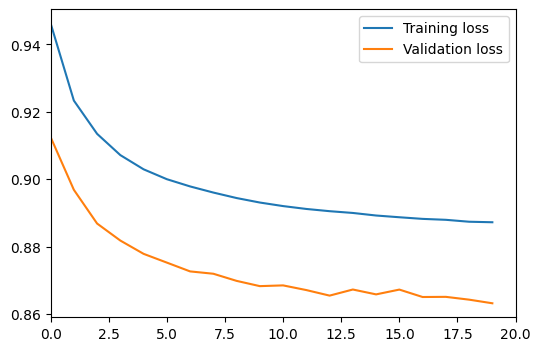

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)


Validation loss decreased (inf --> 0.912501).  Saving model ...


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Validation loss decreased (0.912501 --> 0.896875).  Saving model ...
Validation loss decreased (0.896875 --> 0.886875).  Saving model ...
Validation loss decreased (0.886875 --> 0.881826).  Saving model ...
Validation loss decreased (0.881826 --> 0.877892).  Saving model ...
Validation loss decreased (0.877892 --> 0.875295).  Saving model ...
Validation loss decreased (0.875295 --> 0.872686).  Saving model ...
Validation loss decreased (0.872686 --> 0.871994).  Saving model ...
Validation loss decreased (0.871994 --> 0.869881).  Saving model ...
Validation loss decreased (0.869881 --> 0.868321).  Saving model ...
Validation loss decreased (0.868321 --> 0.867153).  Saving model ...
Validation loss decreased (0.867153 --> 0.865511).  Saving model ...
Validation loss decreased (0.865511 --> 0.865098).  Saving model ...
Validation loss decreased (0.865098 --> 0.864314).  Saving model ...
Validation loss decreased (0.864314 --> 0.863240).  Saving model ...


In [221]:
epochs = 20
lr = 0.0001 # 0.005 is very slow


# CrossEntropyLoss expects raw prediction values while NLLLoss expects log probabilities.
# criterion = nn.CrossEntropyLoss() # nn.NLLLoss()
# since we are using nn.LogSoftmax as final layer at model  
criterion = nn.NLLLoss()

optimizer = AdamW(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

early_stopper = EarlyStopper(patience=5)

mb = master_bar(range(epochs))
mb.names = ['Training loss', 'Validation loss']

x = []
training_losses = []
validation_losses = []

valid_mean_min = np.Inf

till_batch = 100

for epoch in mb:
  x.append(epoch)
  # Train
  i = 0
  model.train()
  total_loss = torch.Tensor([0.0]).to(device)
  for batch in progress_bar(train_dataloader, parent=mb):
    model.zero_grad()
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = model(input)
    loss = criterion(output, label)
    # backward propagation
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      total_loss += loss.item()
    i += 1
    #if i == till_batch:
    #  break

  # decay lr
  scheduler.step()

  mean = total_loss / len(train_dataloader)
  #mean = total_loss / till_batch
  training_losses.append(mean.cpu())

  # Evaluate
  i = 0
  model.eval()
  validation_loss = torch.Tensor([0.0]).to(device)
  with torch.no_grad():
    for batch in progress_bar(val_dataloader, parent=mb):
      input = batch[0].to(device)
      label = batch[1].to(device)
      output = model(input)
      loss = criterion(output, label)
      validation_loss += loss.item()
      i += 1
      #if i == till_batch:
      #  break

  val_mean = validation_loss / len(val_dataloader)
  #val_mean = validation_loss / till_batch

  validation_losses.append(val_mean.cpu())
  # Update training chart
  mb.update_graph([[x, training_losses], [x, validation_losses]], [0,epochs])
  mb.write(f"\nEpoch {epoch}: Training loss {mean.item():.6f} validation loss {val_mean.item():.6f} with lr {lr:.6f}")
  # save model if validation loss has decreased
  if val_mean.item() <= valid_mean_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_mean_min,
      val_mean.item()))
      torch.save(model.state_dict(), 'simple_transformer_ethni.pt')
      valid_mean_min = val_mean.item()

  if early_stopper.early_stop(val_mean.item()):             
        break

## Save Model

In [222]:
torch.save(model.state_dict(), 'ethnicolor_transformer_label_pytorch.pt')

## Testing

In [223]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [224]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# track test loss
test_loss = 0.0


class_correct = list(0. for i in range(n_categories))
class_total = list(0. for i in range(n_categories))


actual = []
predictions = []

model.eval()
# iterate over test data
pbar = tqdm(test_dataloader, total=len(test_dataloader), position=0, desc="Testing", leave=True)
for batch in pbar:
    # move tensors to GPU if CUDA is available
    input = batch[0].to(device)
    label = batch[1].to(device)
    output = model(input)
    loss = criterion(output, label)
    test_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(label.shape[0]):
        l = label.data[i]
        class_correct[l.long()] += correct[i].item()
        class_total[l.long()] += 1
        # for confusion matrix    
        actual.append(all_categories[label.data[i].item()])
        predictions.append(all_categories[pred.data[i].item()])


# plot confusion matrix
cm = confusion_matrix(actual, predictions, labels=all_categories)
print(classification_report(actual, predictions))

Testing: 100%|██████████| 8122/8122 [02:14<00:00, 60.56it/s]


              precision    recall  f1-score   support

       asian       0.67      0.17      0.27     28820
    hispanic       0.69      0.58      0.63    178919
    nh_black       0.60      0.12      0.20    159268
    nh_white       0.70      0.94      0.80    631788
       other       0.34      0.01      0.01     40821

    accuracy                           0.69   1039616
   macro avg       0.60      0.36      0.38   1039616
weighted avg       0.67      0.69      0.63   1039616



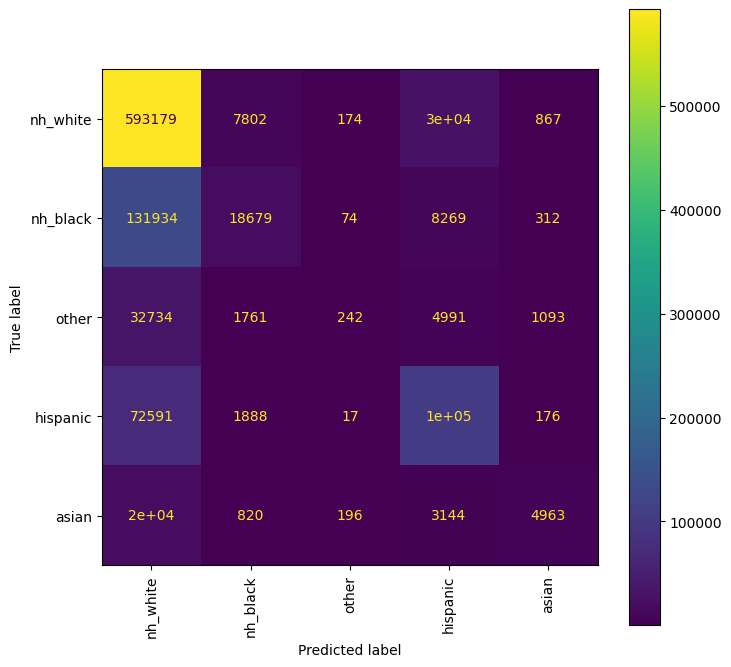

In [225]:
import matplotlib.pyplot as plt
%matplotlib inline  

cmp = ConfusionMatrixDisplay(cm, display_labels=all_categories)
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation='vertical')

In [226]:
# average test loss
test_loss = test_loss/len(test_dataloader)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(all_categories)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            all_categories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (all_categories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.864993

Test Accuracy of nh_white: 93% (593179/631788)
Test Accuracy of nh_black: 11% (18679/159268)
Test Accuracy of other:  0% (242/40821)
Test Accuracy of hispanic: 58% (104247/178919)
Test Accuracy of asian: 17% (4963/28820)

Test Accuracy (Overall): 69% (721310/1039616)


In [227]:
name = "Ward Stephanie"
name_tokens = lineToTensor(name)
inp = name_tokens
print(inp.shape)
out = model(inp.unsqueeze(0).to(device))
print(out.shape)
out = torch.argmax(out)
print(out)
print(all_categories[out.item()])

torch.Size([47])
torch.Size([1, 5])
tensor(0, device='cuda:0')
nh_white
